In [3]:
import numpy as np
import pickle
import os
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

In [151]:
def bin_data(y, n_bins):
    """
    Partitions the data into ordered bins based on
    the probabilities. Returns the binned indices.
    """
    edges = np.linspace(0, 1, n_bins)
    bin_idx = np.digitize(y, edges, right=True)
    binned_idx = [np.where(bin_idx == i)[0] for i in range(n_bins)]
    
    return binned_idx
    
def bin_stats(y_true, y_proba, bin_idx):
    # mean accuracy within each bin
    bin_acc = [
        np.equal(np.argmax(y_proba[idx], axis=1), y_true[idx]).mean() if len(idx) > 0 else 0
        for idx in bin_idx
    ]
    # mean confidence of prediction within each bin
    bin_conf = [
        np.mean(np.max(y_proba[idx], axis=1)) if len(idx) > 0 else 0
        for idx in bin_idx 
    ]
    
    return np.asarray(bin_acc), np.asarray(bin_conf)

def ece(y_true, y_proba, n_bins=10):
    bin_idx = bin_data(y_proba.max(axis=1), n_bins)
    n = len(y_true)
    
    bin_acc, bin_conf = bin_stats(y_true, y_proba, bin_idx)
    bin_sizes = [len(idx) for idx in bin_idx]
    
    ece = np.sum(np.abs(bin_acc - bin_conf) * np.asarray(bin_sizes)) / n
    
    return ece

def mce(y_true, y_proba, n_bins=10):
    bin_idx = bin_data(y_proba.max(axis=1), n_bins)
    
    bin_acc, bin_conf = bin_stats(y_true, y_proba, bin_idx)
    mce = np.max(np.abs(bin_acc - bin_conf))
    
    return mce

def brier_score_mvloss(y_true, y_proba):
    if y_true.ndim == 1:
        y_true = np.squeeze(np.eye(len(np.unique(y_true)))[y_true.reshape(-1)])
    return np.mean(
        np.mean((y_proba - y_true)**2, axis=1)
    )

In [142]:
clfs = ['RF', 'IRF', 'SigRF', 'UF']

In [143]:
def get_task_scores(score_fn, results_dir='./results_cv5/'):
    tasks = []
    task_score_means = []
    task_score_stds = []
    for file in os.listdir(results_dir):
        with open(results_dir + file, 'rb') as f:
            results_dict = pickle.load(f)

        score_means = [
            np.mean([
                score_fn(
                    results_dict['y'][idx], y_proba
                ) for y_proba, idx in zip(results_dict[name], results_dict['test_indices'])
            ]) for name in clfs
        ]

        score_stds = [
            np.std([
                score_fn(
                    results_dict['y'][idx], y_proba
                ) for y_proba, idx in zip(results_dict[name], results_dict['test_indices'])
            ]) for name in clfs
        ]
        
        tasks.append(
            {k: results_dict[k] for k in ['task_id', 'task', 'n_samples', 'n_classes', 'n_features']
            })
        task_score_means.append(score_means)
        task_score_stds.append(score_stds)

    return tasks, task_score_means, task_score_stds

## CSVs

### Brier

In [19]:
tasks, task_score_means, task_score_stds = get_task_scores(brier_score_mvloss)

df_rows = []
for task, score_means, score_stds in zip(tasks, task_score_means, task_score_stds):
    row = [f'{m:.3f} ({s:.3f})' for m, s in zip(score_means, score_stds)]
    row = [task['task'], task['n_classes'], task['n_samples'], task['n_features']] + row
    df_rows.append(row)
header = ['Dataset', 'n_classes', 'n_samples', 'n_features'] + clfs

In [29]:
score_df = pd.DataFrame(
    df_rows, columns=header, index=[task['task_id'] for task in tasks]
).sort_index()

In [30]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(score_df)

                                       Dataset  n_classes  n_samples  \
3                                     kr-vs-kp          2       3196   
6                                       letter         26      20000   
11                               balance-scale          3        625   
12                               mfeat-factors         10       2000   
14                               mfeat-fourier         10       2000   
15                                    breast-w          2        699   
16                              mfeat-karhunen         10       2000   
18                         mfeat-morphological         10       2000   
22                               mfeat-zernike         10       2000   
23                                         cmc          3       1473   
28                                   optdigits         10       5620   
29                             credit-approval          2        690   
31                                    credit-g          2       

In [14]:
score_df.to_csv('./figures/brier_scores.csv')

### ECE

In [146]:
tasks, task_score_means, task_score_stds = get_task_scores(ece)

df_rows = []
for task, score_means, score_stds in zip(tasks, task_score_means, task_score_stds):
    row = [f'{m:.3f} ({s:.3f})' for m, s in zip(score_means, score_stds)]
    row = [task['task'], task['n_classes'], task['n_samples'], task['n_features']] + row
    df_rows.append(row)
header = ['Dataset', 'n_classes', 'n_samples', 'n_features'] + clfs

In [147]:
score_df = pd.DataFrame(
    df_rows, columns=header, index=[task['task_id'] for task in tasks]
).sort_index()

In [148]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(score_df)

                                       Dataset  n_classes  n_samples  \
3                                     kr-vs-kp          2       3196   
6                                       letter         26      20000   
11                               balance-scale          3        625   
12                               mfeat-factors         10       2000   
14                               mfeat-fourier         10       2000   
15                                    breast-w          2        699   
16                              mfeat-karhunen         10       2000   
18                         mfeat-morphological         10       2000   
22                               mfeat-zernike         10       2000   
23                                         cmc          3       1473   
28                                   optdigits         10       5620   
29                             credit-approval          2        690   
31                                    credit-g          2       

In [149]:
score_df.to_csv('./figures/ece_scores.csv')

### MCE

In [152]:
tasks, task_score_means, task_score_stds = get_task_scores(mce)

df_rows = []
for task, score_means, score_stds in zip(tasks, task_score_means, task_score_stds):
    row = [f'{m:.3f} ({s:.3f})' for m, s in zip(score_means, score_stds)]
    row = [task['task'], task['n_classes'], task['n_samples'], task['n_features']] + row
    df_rows.append(row)
header = ['Dataset', 'n_classes', 'n_samples', 'n_features'] + clfs

In [153]:
score_df = pd.DataFrame(
    df_rows, columns=header, index=[task['task_id'] for task in tasks]
).sort_index()

# Plots

In [32]:
import seaborn as sns

In [137]:
def continuous_pairplot(df, vars, hue, cmap, diag_kind, scale='log'):
    import matplotlib as mpl
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    g = sns.pairplot(
        df,
        vars=vars,
        diag_kind=diag_kind,
        plot_kws=dict(c=df[hue], cmap=cmap),
    )
    if scale:
        for r in range(len(g.axes)):
            for c in range(len(g.axes)):
                g.axes[r , c].set_xscale(scale)
                if r != c:
                    g.axes[c , r].set_yscale(scale)

    vmax = np.max(np.abs([df[hue]]))
    sm = mpl.cm.ScalarMappable(
        norm=mpl.colors.Normalize(
            vmin=-vmax, vmax=vmax, clip=False),
        cmap=cmap
    )
    plt.colorbar(sm, ax=g.axes, label=hue, aspect=40)
    
    return g

## Brier Score

In [42]:
tasks, task_score_means, task_score_stds = get_task_scores(brier_score_mvloss)

df_rows = []
for task, score_means, score_stds in zip(tasks, task_score_means, task_score_stds):
    row = np.round(score_means, 4)
    row = [task['task'], task['n_classes'], task['n_samples'], task['n_features']] + list(row)
    df_rows.append(row)
header = ['Dataset', 'n_classes', 'n_samples', 'n_features'] + clfs

In [43]:
score_df = pd.DataFrame(
    df_rows, columns=header, index=[task['task_id'] for task in tasks]
).sort_index()

In [45]:
for col in ['RF', 'IRF', 'SigRF']:
    score_df[f'UF_reldiff_{col}'] = score_df.apply(lambda row: (row['UF'] - row[col]) / row['UF'], axis=1)

In [47]:
score_df['UF_reldiff_max'] = score_df.apply(lambda row: max([row[f'UF_reldiff_{col}'] for col in ['RF', 'IRF', 'SigRF']]), axis=1)

In [48]:
score_df

,Dataset,n_classes,n_samples,n_features,RF,IRF,SigRF,UF,UF_reldiff_RF,UF_reldiff_IRF,UF_reldiff_SigRF,UF_reldiff_max
3,kr-vs-kp,2,3196,36,0.0257,0.0242,0.0240,0.0178,-0.443820,-0.359551,-0.348315,-0.348315
6,letter,26,20000,16,0.0367,0.0367,0.0367,0.0367,0.000000,0.000000,0.000000,0.000000
11,balance-scale,3,625,4,0.1654,0.1738,0.1898,0.1653,-0.000605,-0.051422,-0.148215,-0.000605
12,mfeat-factors,10,2000,216,0.0877,0.0830,0.0832,0.0897,0.022297,0.074693,0.072464,0.074693
14,mfeat-fourier,10,2000,76,0.0901,0.0900,0.0900,0.0900,-0.001111,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
167119,jungle_chess_2pcs_raw_endgame_complete,3,44819,6,0.1829,0.1835,0.1857,0.1829,0.000000,-0.003280,-0.015309,0.000000
167120,numerai28.6,2,96320,21,0.2501,0.2500,0.2500,0.2501,0.000000,0.000400,0.000400,0.000400
167125,Internet-Advertisements,2,3279,1558,0.0287,0.0293,0.0295,0.0377,0.238727,0.222812,0.217507,0.238727
167140,dna,3,3186,180,0.0440,0.0225,0.0226,0.0367,-0.198910,0.386921,0.384196,0.386921


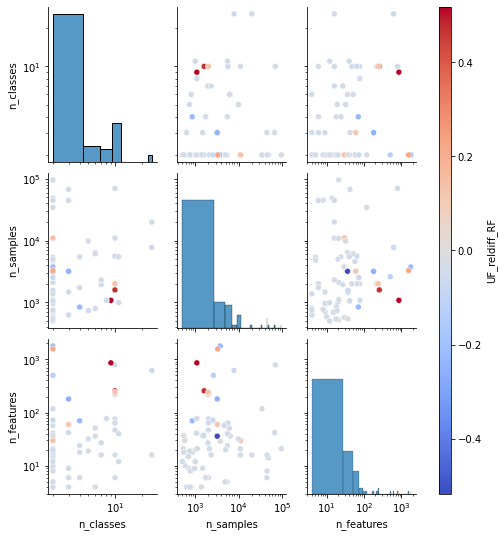

In [138]:
continuous_pairplot(
    score_df,
    vars=['n_classes', 'n_samples', 'n_features'],
    hue='UF_reldiff_RF',
    cmap='coolwarm',
    diag_kind='hist')

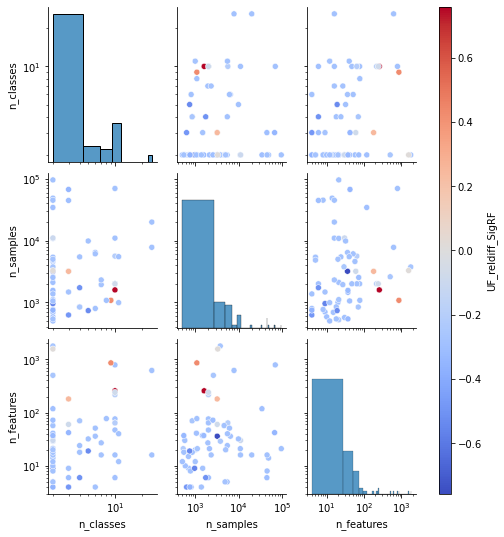

In [139]:
continuous_pairplot(
    score_df,
    vars=['n_classes', 'n_samples', 'n_features'],
    hue='UF_reldiff_SigRF',
    cmap='coolwarm',
    diag_kind='hist')

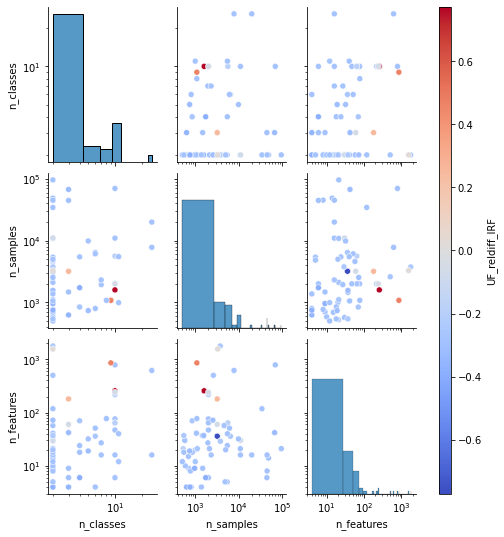

In [140]:
continuous_pairplot(
    score_df,
    vars=['n_classes', 'n_samples', 'n_features'],
    hue='UF_reldiff_IRF',
    cmap='coolwarm',
    diag_kind='hist')